# Tree building M 

In this notebook I sequentially build the best tree for patient M. The process goes as follows:

1. Build a tree class with the data as attribute
2. Find the 2 most covered mutations and build all potential trees
3. Run SVI on each tree independently
4. Select any tree with lowest ELBO in the last 50 iterations
5. Add the next most covered mutation and generate all potential trees
6. Repeat 3-5 until trees contain all mutations
7. Select one of the best trees and compute clonal assignment probabilities for single-cells

## Import packages 



<br>



In [1]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os

import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, Predictive
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [2]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
#torch.set_default_tensor_type(torch.FloatTensor)
#torch.autograd.set_detect_anomaly(True)
patient = "AKLM"

## Load data

In [3]:
# load data from patient W
with open("data/"+patient+"_mito_filtered.json") as f:
    data = json.load(f)
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([2, 0])


In [4]:
data['colnames']

['X7075.G.A', 'chr7']

# Build tree M

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 


In [5]:
data_svi = {"M": torch.Tensor(data["M"]),
             "N": torch.Tensor(data["N"]),
             "mut_type": torch.Tensor([2,0]),
             "h_alpha": torch.Tensor([1.,2.]),
             "h_beta": torch.Tensor([1.,100.]),
             "af_alpha": torch.Tensor([[1, 9], [1,1], [1,1]]),
             "af_beta": torch.Tensor([[1, 100-9],[1,1], [1,1]]),
             "r_cnv": torch.Tensor([0,0.75]),
             "names": data["colnames"],
             "barcodes": data["cell_barcode"], 
             "umapx": data["umapx"], 
             "umapy": data["umapy"],
             "class_af": True, 
             "class_assign": torch.cuda.IntTensor(data["timepoint"]),
             "class_names": ["day0", "day15", "day23"],
             "cnv_celltype": True,
             "celltype": torch.tensor(data["celltypes"])-1,
             "celltype_names": data["celltype_names"],
             "cnv_ct_mean": torch.Tensor(data["cnv_priors"]["mean"]),
             "cnv_ct_sd": torch.tensor(data["cnv_priors"]["sd"][0])}

In [6]:
t = tree(patient, data_svi)
t.sel_mutation(initial = True)

tensor([1, 0])

## Find best tree for chr7 & mt:7075G>A

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 3m 51s
Model fit to tree 1 in 3m 30s
Model fit to tree 2 in 3m 36s
Model fit to tree 3 in 3m 41s
Tree [2] selected for mutations ['chr7', 'X7075.G.A']:
[tensor([[0., 0.],
        [1., 0.],
        [0., 1.]])]
Total run time 0h 14m 39s


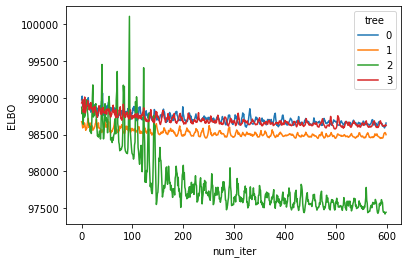

In [7]:
# add mutation and select the best tree(s)
t.select_tree(num_iter = 750, init = 150)

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 3m 6s
Model fit to tree 1 in 3m 5s
Model fit to tree 2 in 3m 6s
Model fit to tree 3 in 3m 6s
Tree [2] selected for mutations ['chr7', 'X7075.G.A']:
[tensor([[0., 0.],
        [1., 0.],
        [0., 1.]])]
Total run time 0h 12m 26s


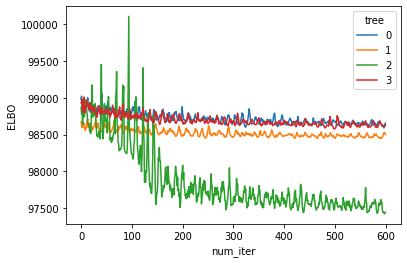

In [7]:
# add mutation and select the best tree(s)
t.select_tree(num_iter = 750, init = 150)

### Plot ELBO

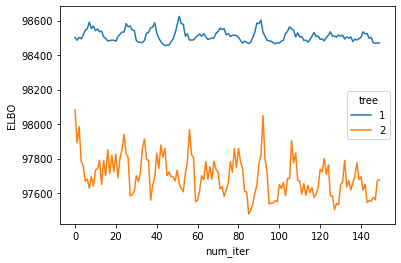

In [8]:
t.print_elbo(500, 350, include = [1,2])

### Plot params

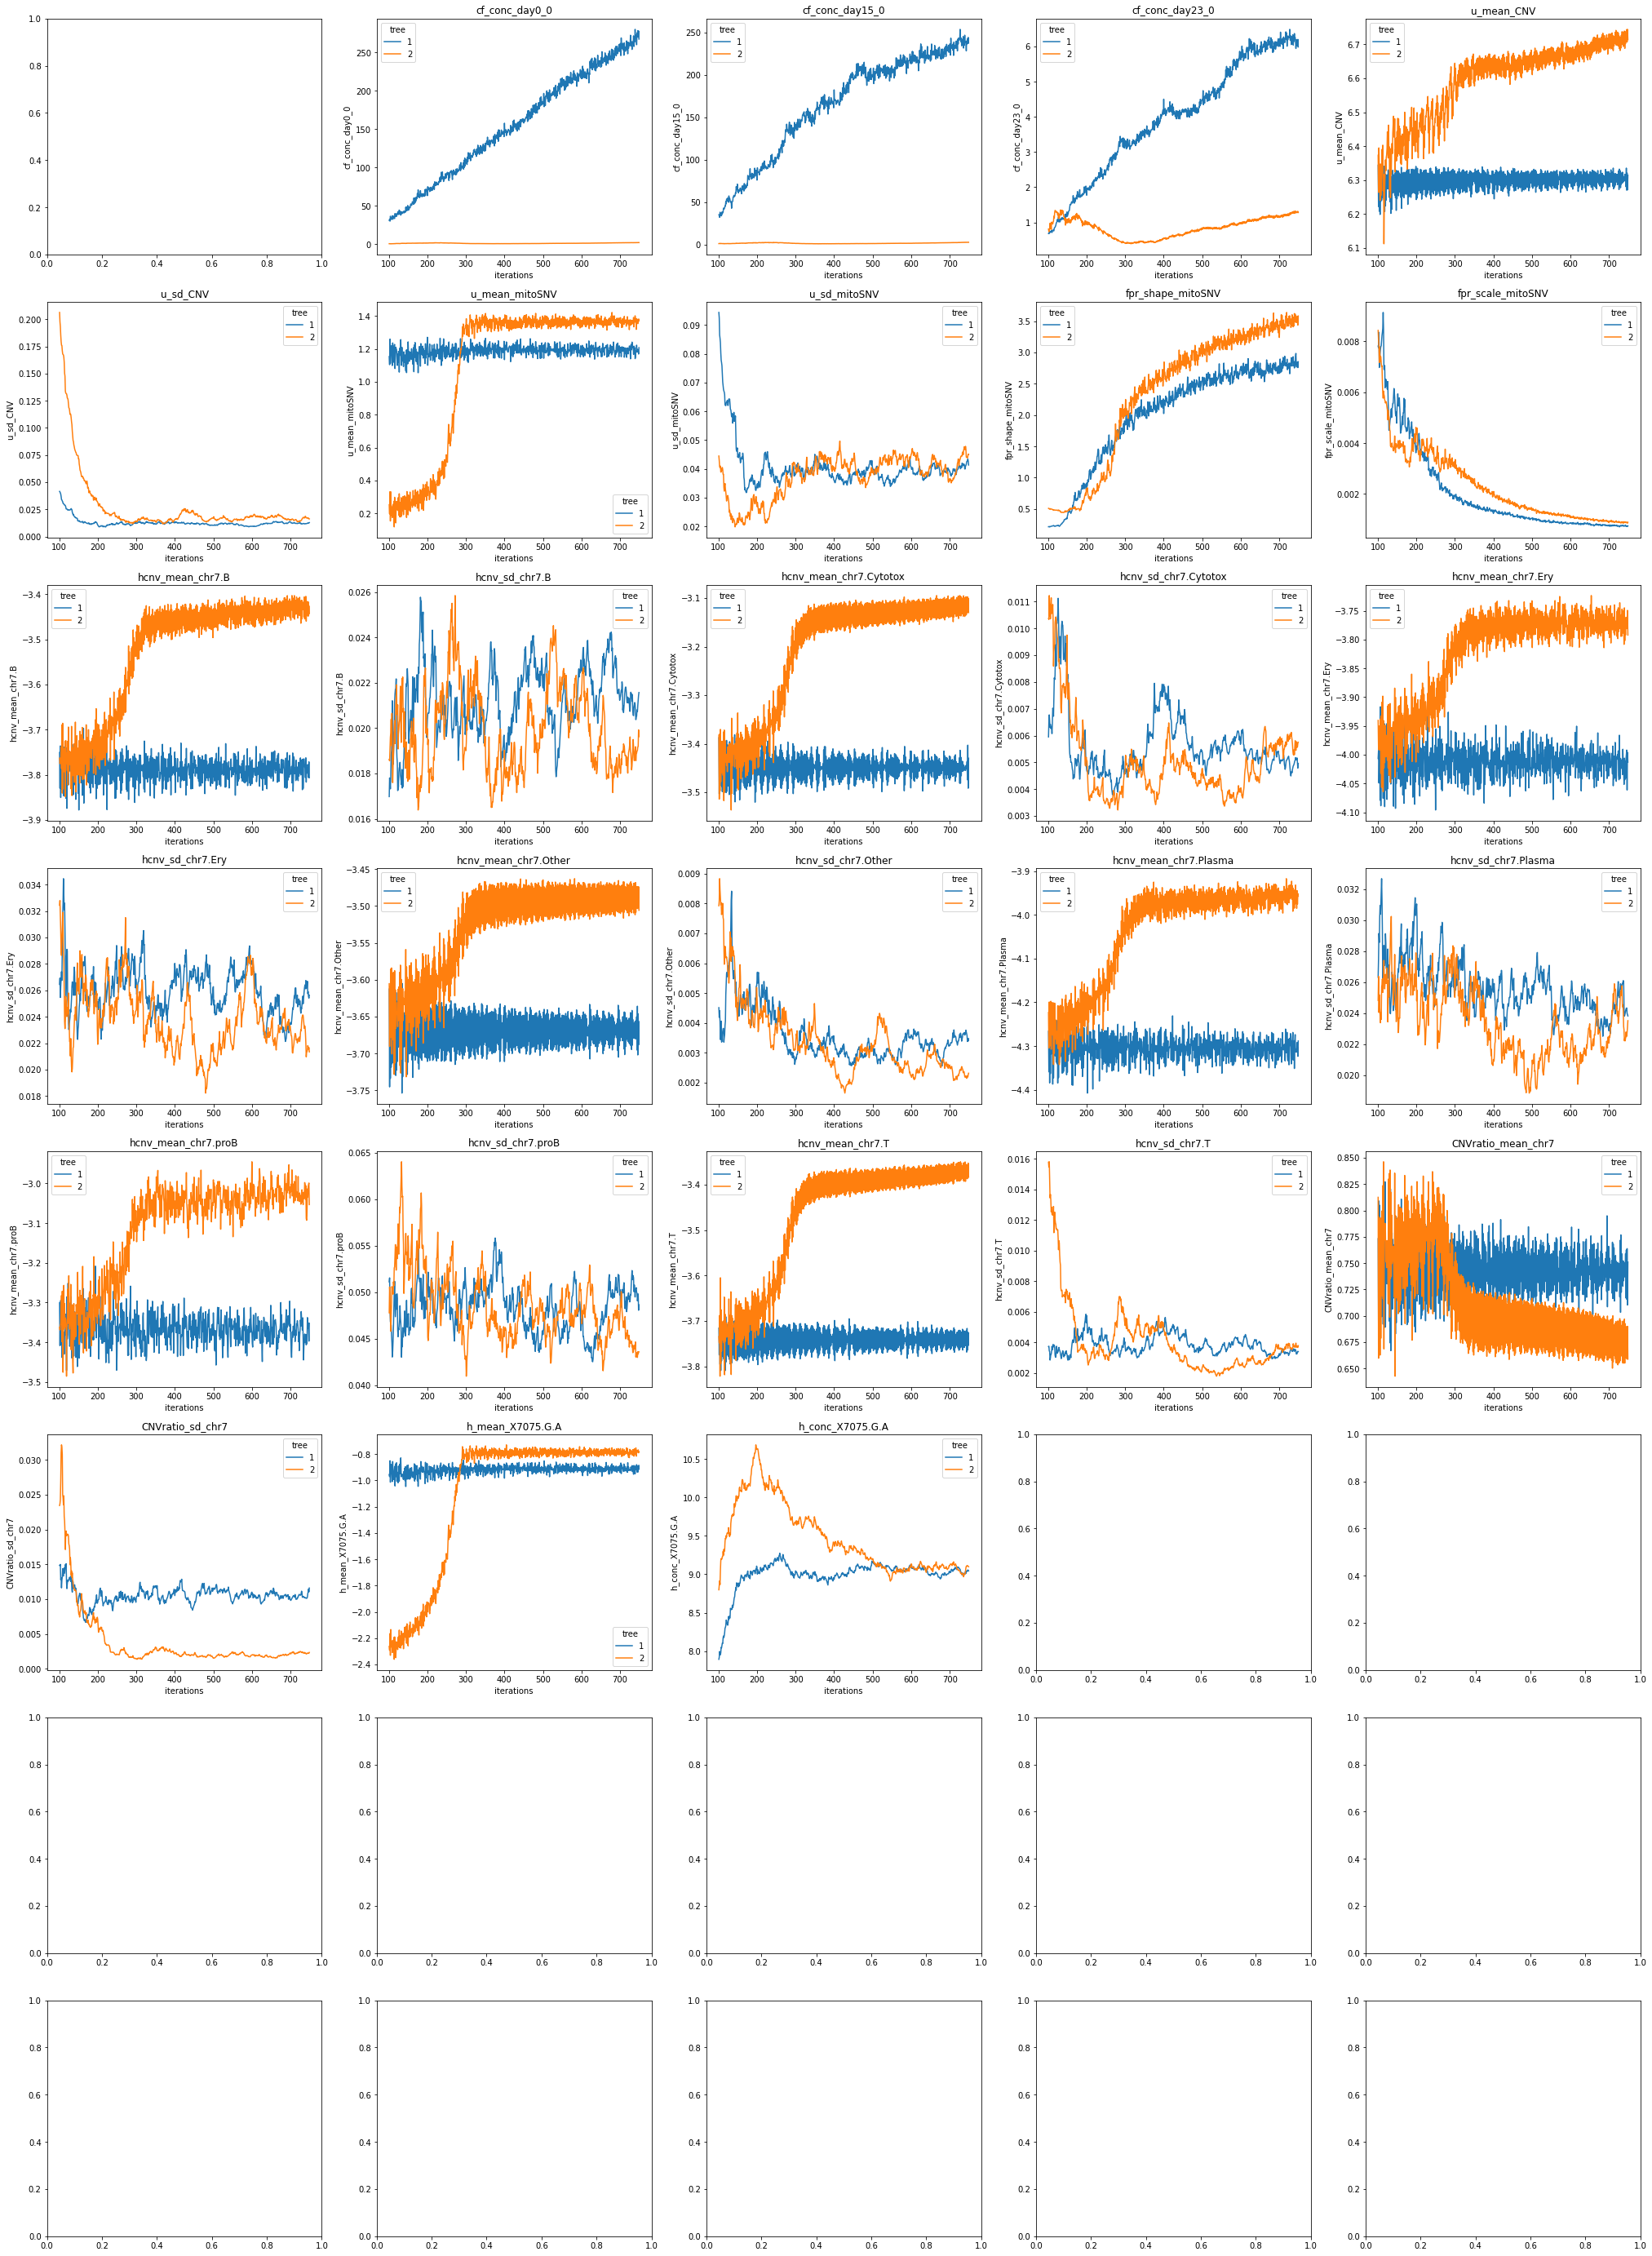

In [9]:
t.print_params(include = [1,2], it = 100)

### Plot posterior distributions

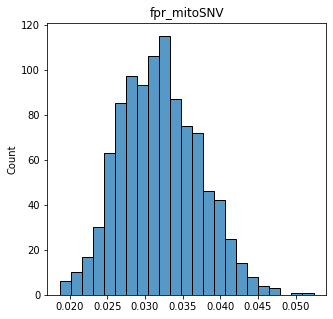

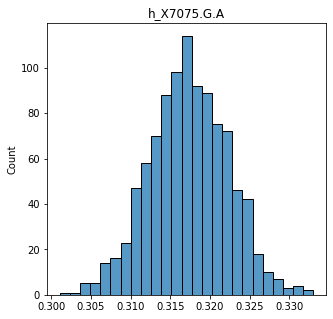

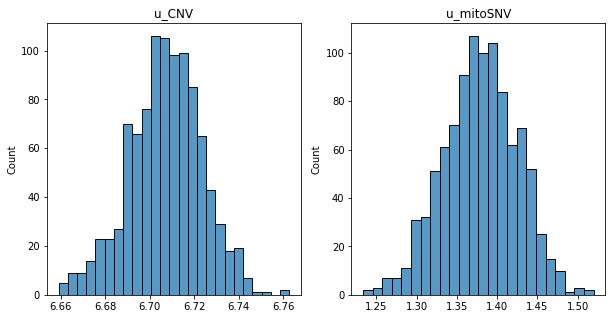

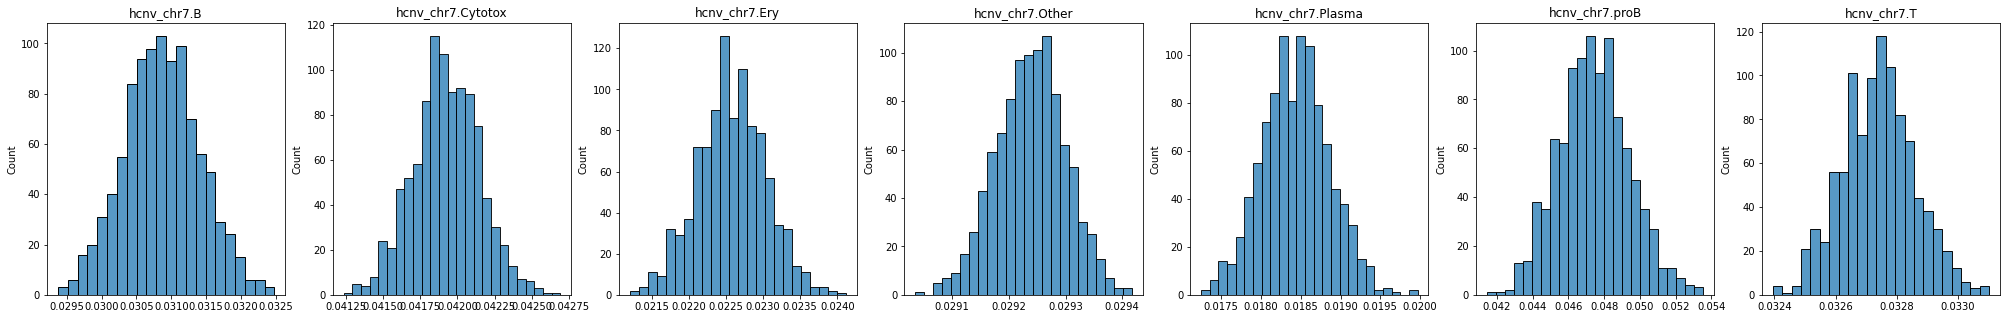

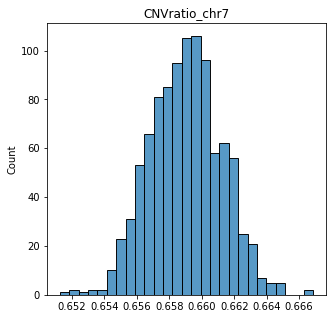

In [10]:
t.plot_posterior("all", 2, 1000)

### Compute Clonal probabilities

In [11]:
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 3m and 12s


## Posterior predictive distributions

Here I compute posterior predictive distributions for the latent variables. I generate as many samples as number cells so that we can later simulate data with these parameters to carry out posterior predictive checks compared to the raw data.

In [14]:
t.get_post_predictive(tree = 2, num_samples = t.M.shape[0])
with open("svi_objects/tree_M.pickle", "wb") as f:
    pickle.dump(t,f, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# export object as pickle
t.export_pickle("svi_objects/AKLM.pickle")

Tree object saved as pickle!


In [11]:
with open("svi_objects/tree_M.pickle", "rb") as f:
    t = pickle.load(f)

# Run simple model

We run the simple model to compare posterior predictive distributions

In [6]:
data_svi = {"M": torch.Tensor(data["M"]),
             "N": torch.Tensor(data["N"]),
             "mut_type": torch.Tensor([2,0]),
             "h_alpha": torch.Tensor([1.,2.]),
             "h_beta": torch.Tensor([1.,100.]),
             "af_alpha": torch.Tensor([[1, 9], [1,1], [1,1]]),
             "af_beta": torch.Tensor([[1, 100-9],[1,1], [1,1]]),
             "r_cnv": torch.Tensor([0,0.75]),
             "names": data["colnames"],
             "barcodes": data["cell_barcode"], 
             "umapx": data["umapx"], 
             "umapy": data["umapy"],
             "class_af": True, 
             "class_assign": torch.cuda.IntTensor(data["timepoint"]),
             "class_names": ["day0", "day15", "day23"],
             "cnv_celltype": False,
             "celltype": [],
             "celltype_names": [],
             "cnv_ct_mean": [],
             "cnv_ct_sd": []}

In [7]:
t = tree(patient, data_svi)
t.sel_mutation(initial = True)

tensor([1, 0])

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 4m 13s
Model fit to tree 1 in 4m 12s
Model fit to tree 2 in 4m 13s
Model fit to tree 3 in 4m 13s
Trees [0, 3] selected for mutations ['chr7', 'X7075.G.A']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 16m 53s


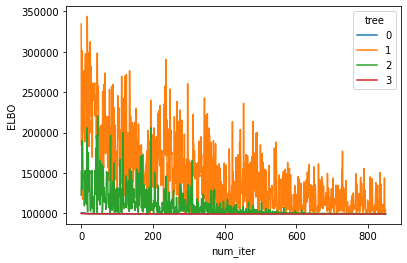

In [26]:
# add mutation and select the best tree(s)
t.select_tree(num_iter = 1000, init = 150)

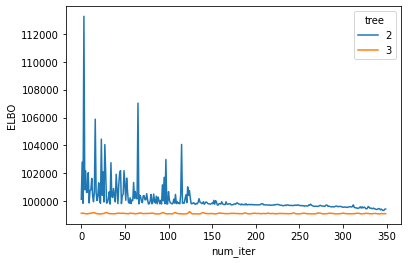

In [27]:
t.print_elbo(1000, 650, include = [2,3])

In [28]:
t.tree = [t.potential_trees[2], t.potential_trees[3]]

In [29]:
t.tree_indices = [2,3]

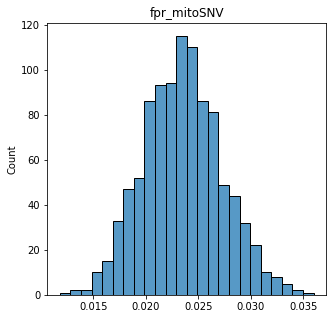

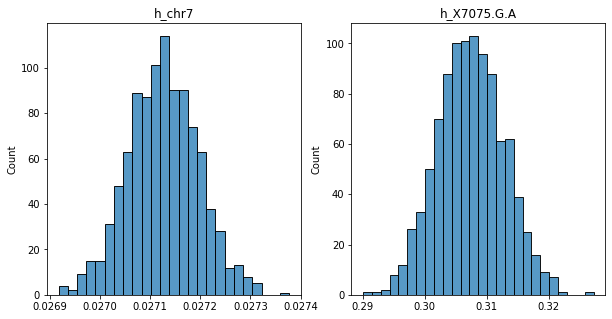

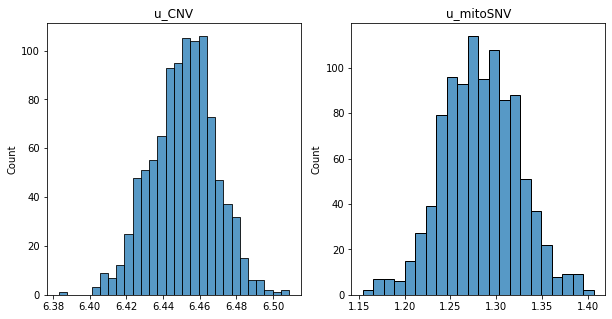

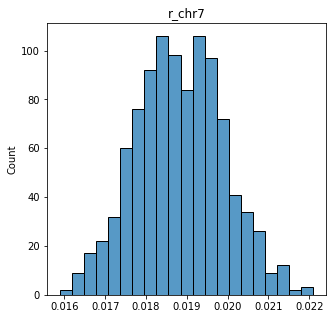

In [30]:
t.plot_posterior("all", 2,1000)

In [4]:
# compute clonal probs
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 3m and 30s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 3m and 31s


In [8]:
t.get_post_predictive(tree = 2, num_samples = t.M.shape[0])
with open("svi_objects/tree_M_simple.pickle", "wb") as f:
    pickle.dump(t,f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# with open("svi_objects/tree_M_simple.pickle", "rb") as f:
#     t = pickle.load(f)

In [9]:
t.export_pickle("svi_objects/AKLM_simple.pickle")

Tree object saved as pickle!


{1: tensor([[0.0052, 0.9764, 0.0184],
         [0.0125, 0.1312, 0.8563],
         [0.0615, 0.6884, 0.2501],
         ...,
         [0.0094, 0.9323, 0.0583],
         [0.0075, 0.9830, 0.0095],
         [0.0153, 0.9435, 0.0412]], grad_fn=<DivBackward0>),
 2: tensor([[0.9754, 0.0246],
         [0.1770, 0.8230],
         [0.7609, 0.2391],
         ...,
         [0.9351, 0.0649],
         [0.9889, 0.0111],
         [0.9577, 0.0423]], grad_fn=<DivBackward0>)}